## Libraries

## Finish dealing with categorical vars, then do imputation via MICE, then create lin model

In [73]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy.stats import norm
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats


import warnings

## Data Cleaning

In [74]:
# Reading in Data

file_path = "./datasets/nhanes_hba1c_merged.csv"
df = pd.read_csv(file_path)

In [75]:
# Initial Data Cleaning

print("Row Number:", df.shape[0])
print("Rows with HbA1c (LBXGH):", df["LBXGH"].notna().sum())
print("Rows with age + HbA1c:", df[["RIDAGEYR", "LBXGH"]].dropna().shape[0])

duplicate_seqn = df["SEQN"].duplicated().sum()
print("Duplicate SEQN entries:", duplicate_seqn)

empty_cols = [col for col in df.columns if df[col].isnull().all()]
print(f"Empty Columns: {empty_cols}")
df = df.drop(empty_cols, axis=1)

nan_count = df.isnull().sum()
na_percentage = (nan_count / 9254)*100
na_high = (na_percentage > 40).sum()
print(f"Number of Columns with greater than 40% of values being NA: {na_high}")
df = df.loc[:, df.isna().mean() < 0.4]

missing_lbxgh = df['LBXGH'].isna().sum()
print(f"Rows with missing LBXGH (HbA1c): {missing_lbxgh}")
df = df.dropna(subset=['LBXGH'])

irrelevant_cols = [
    'SDDSRVYR', 'RIDSTATR',
    'SIALANG', 'SIAPROXY', 'SIAINTRP',
    'FIALANG', 'FIAPROXY', 'FIAINTRP',
    'MIALANG', 'MIAPROXY', 'MIAINTRP',
    'DMDHRGND', 'DMDHRAGZ', 'DMDHREDZ', 'DMDHRMAZ',
    'SDMVPSU', 'SDMVSTRA',
    'BMDSTATS', 'DIQ010', 'DIQ160', 'DIQ170'	
    ,'DIQ172'	
    ,'DIQ180', 'DIQ050', 'WTINT2YR', 'WTMEC2YR', 'SDMVPSU', 'SDMVSTRA', "RIDEXMON"
]

print(f"Irrelevant Col Count: {len(irrelevant_cols)}")
df = df.drop(irrelevant_cols, axis=1)

print(f"Final Data Shape: {df.shape}")

Row Number: 9254
Rows with HbA1c (LBXGH): 6045
Rows with age + HbA1c: 6045
Duplicate SEQN entries: 0
Empty Columns: ['BMIHEAD']
Number of Columns with greater than 40% of values being NA: 65
Rows with missing LBXGH (HbA1c): 3209
Irrelevant Col Count: 29
Final Data Shape: (6045, 27)


In [ ]:
# Listing Variable definitions for later reference

nhanes_variable_dict = {
    "SEQN": "Respondent sequence number (unique identifier)",
    "RIAGENDR": "Gender of respondent (1=Male, 2=Female)",
    "RIDAGEYR": "Age in years at screening",
    "RIDRETH1": "Race/ethnicity (5-level: Mexican Am., Other Hispanic, Non-Hispanic White, Non-Hispanic Black, Other)",
    "RIDRETH3": "Race/ethnicity (6-level: includes multi-racial)",
    "RIDEXMON": "Month of exam (1=November–April, 2=May–October)",
    "DMQMILIZ": "Served active duty in U.S. Armed Forces (1=Yes, 2=No)",
    "DMDBORN4": "Country of birth (1=USA, 2=Other, 3=Don't know/refused)",
    "DMDCITZN": "U.S. citizenship status (1=Citizen by birth, 2=Citizen by naturalization, 3=Non-citizen)",
    "DMDEDUC2": "Education level for adults 20+ (1=<9th grade to 5=College graduate)",
    "DMDMARTL": "Marital status (1=Married, 2=Widowed, ..., 6=Never married)",
    "DMDHHSIZ": "Total number of people in household",
    "DMDFMSIZ": "Total number of family members in household",
    "DMDHHSZA": "Number of children aged 0–5 in household",
    "DMDHHSZB": "Number of children aged 6–17 in household",
    "DMDHHSZE": "Number of adults aged 60+ in household",
    "INDHHIN2": "Household income (categorical levels)",
    "INDFMIN2": "Family income (categorical levels)",
    "INDFMPIR": "Family income to poverty ratio (continuous)",
    "BMXWT": "Weight in kilograms",
    "BMXHT": "Standing height in centimeters",
    "BMXBMI": "Body Mass Index (kg/m²)",
    "BMXLEG": "Upper leg length in centimeters",
    "BMXARML": "Upper arm length in centimeters",
    "BMXARMC": "Arm circumference in centimeters",
    "BMXWAIST": "Waist circumference in centimeters",
    "BMXHIP": "Hip circumference in centimeters",
    "LBXGH": "Glycohemoglobin (HbA1c) (% of total hemoglobin)"
}

# Categorical variables (require encoding)
categorical_vars = [
    "RIAGENDR",     # Gender
    "RIDRETH1",     # Race/ethnicity (5-level)
    "RIDRETH3",     # Race/ethnicity (6-level)
    "DMQMILIZ",     # Military service
    "DMDBORN4",     # Country of birth
    "DMDCITZN",     # Citizenship status
    "DMDEDUC2",     # Education level
    "DMDMARTL"     # Marital status
]

# Numeric variables (can be used directly)
numeric_vars = [
    "RIDAGEYR",     # Age
    "INDFMPIR",     # Income to poverty ratio
    "BMXWT",        # Weight
    "BMXHT",        # Height
    "BMXBMI",       # BMI
    "BMXLEG",       # Leg length
    "BMXARML",      # Arm length
    "BMXARMC",      # Arm circumference
    "BMXWAIST",     # Waist circumference
    "BMXHIP",       # Hip circumference
    "LBXGH",         # HbA1c (target)
    "DMDHHSIZ",     # Household size
    "DMDFMSIZ",     # Family size
    "DMDHHSZA",     # Children 0–5
    "DMDHHSZB",     # Children 6–17
    "DMDHHSZE",     # Adults 60+
    "INDHHIN2",     # Household income
    "INDFMIN2"     # Family income

]

# Not used for modeling (identifier)
id_var = ["SEQN"]

### NA Analysis

#### 1. `DMDEDUC2` and `DMDMARTL` (~17% missing)
- These variables represent **education level** and **marital status**.
- Missingness is strongly associated with age: participants with missing values have a mean age of ~15.
- **Conclusion**: This is **structural missingness** — these questions are not asked of respondents under age 20.

#### 2. `INDFMPIR`, `INDHHIN2`, `INDFMIN2` (4–13% missing)
- These variables are related to **household and family income**.
- Income data is frequently skipped by participants for privacy reasons.
- **Conclusion**: This is likely **non-random missingness** (MAR or MNAR).

#### 3. `DMQMILIZ` (~10.7% missing)
- Indicates whether the respondent has served in the U.S. military.
- Missingness may result from survey skip logic or age restrictions (e.g., not asked of minors).
- **Action**: Treat missing as a separate category or impute based on age and gender if needed.

#### 4. Anthropometric Measurements (1–5% missing)
- Variables like `BMXLEG`, `BMXWAIST`, `BMXHIP`, etc.
- Missingness likely due to **measurement refusal**, equipment error, or skip logic in the physical exam.
- **Conclusion**: Missing at random (likely).
- **Action**: Impute using median values; minimal bias expected.

#### 5. `DMDCITZN` (~0.05% missing)
- U.S. citizenship status — negligible missingness.
- **Action**: Drop or impute safely without concern.

In [77]:
# NA percentage by Column

na_summary = df.isna().mean().sort_values(ascending=False)
print(na_summary)

DMDEDUC2    0.169892
DMDMARTL    0.169892
INDFMPIR    0.126716
DMQMILIZ    0.106865
BMXLEG      0.053102
BMXWAIST    0.049297
BMXHIP      0.047146
INDHHIN2    0.046650
INDFMIN2    0.044003
BMXARMC     0.039371
BMXARML     0.039041
BMXBMI      0.015550
BMXHT       0.014227
BMXWT       0.014061
DMDCITZN    0.000496
SEQN        0.000000
DMDHHSZB    0.000000
DMDHHSZE    0.000000
RIAGENDR    0.000000
DMDHHSZA    0.000000
DMDFMSIZ    0.000000
DMDHHSIZ    0.000000
DMDBORN4    0.000000
RIDRETH3    0.000000
RIDRETH1    0.000000
RIDAGEYR    0.000000
LBXGH       0.000000
dtype: float64


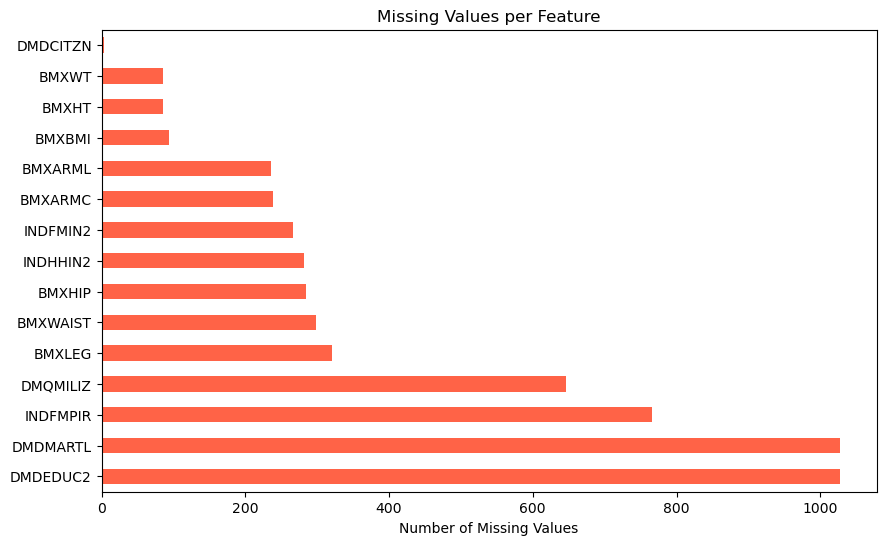

In [ ]:
# Bar Charts of Missing Values

na_counts = df.isna().sum().sort_values(ascending=False)
na_counts = na_counts[na_counts > 0]

na_counts.plot(kind='barh', figsize=(10, 6), color='tomato')
plt.title("Missing Values per Feature")
plt.xlabel("Number of Missing Values")
plt.show()

## Feature Analysis

### Numerical Feature Analysis

RIDAGEYR    1
INDFMPIR    2
BMXWT       4
BMXHT       2
BMXBMI      5
BMXLEG      1
BMXARML     2
BMXARMC     4
BMXWAIST    4
BMXHIP      2
LBXGH       1
DMDHHSIZ    2
DMDFMSIZ    2
DMDHHSZA    1
DMDHHSZB    1
DMDHHSZE    1
INDHHIN2    2
INDFMIN2    3
dtype: int64


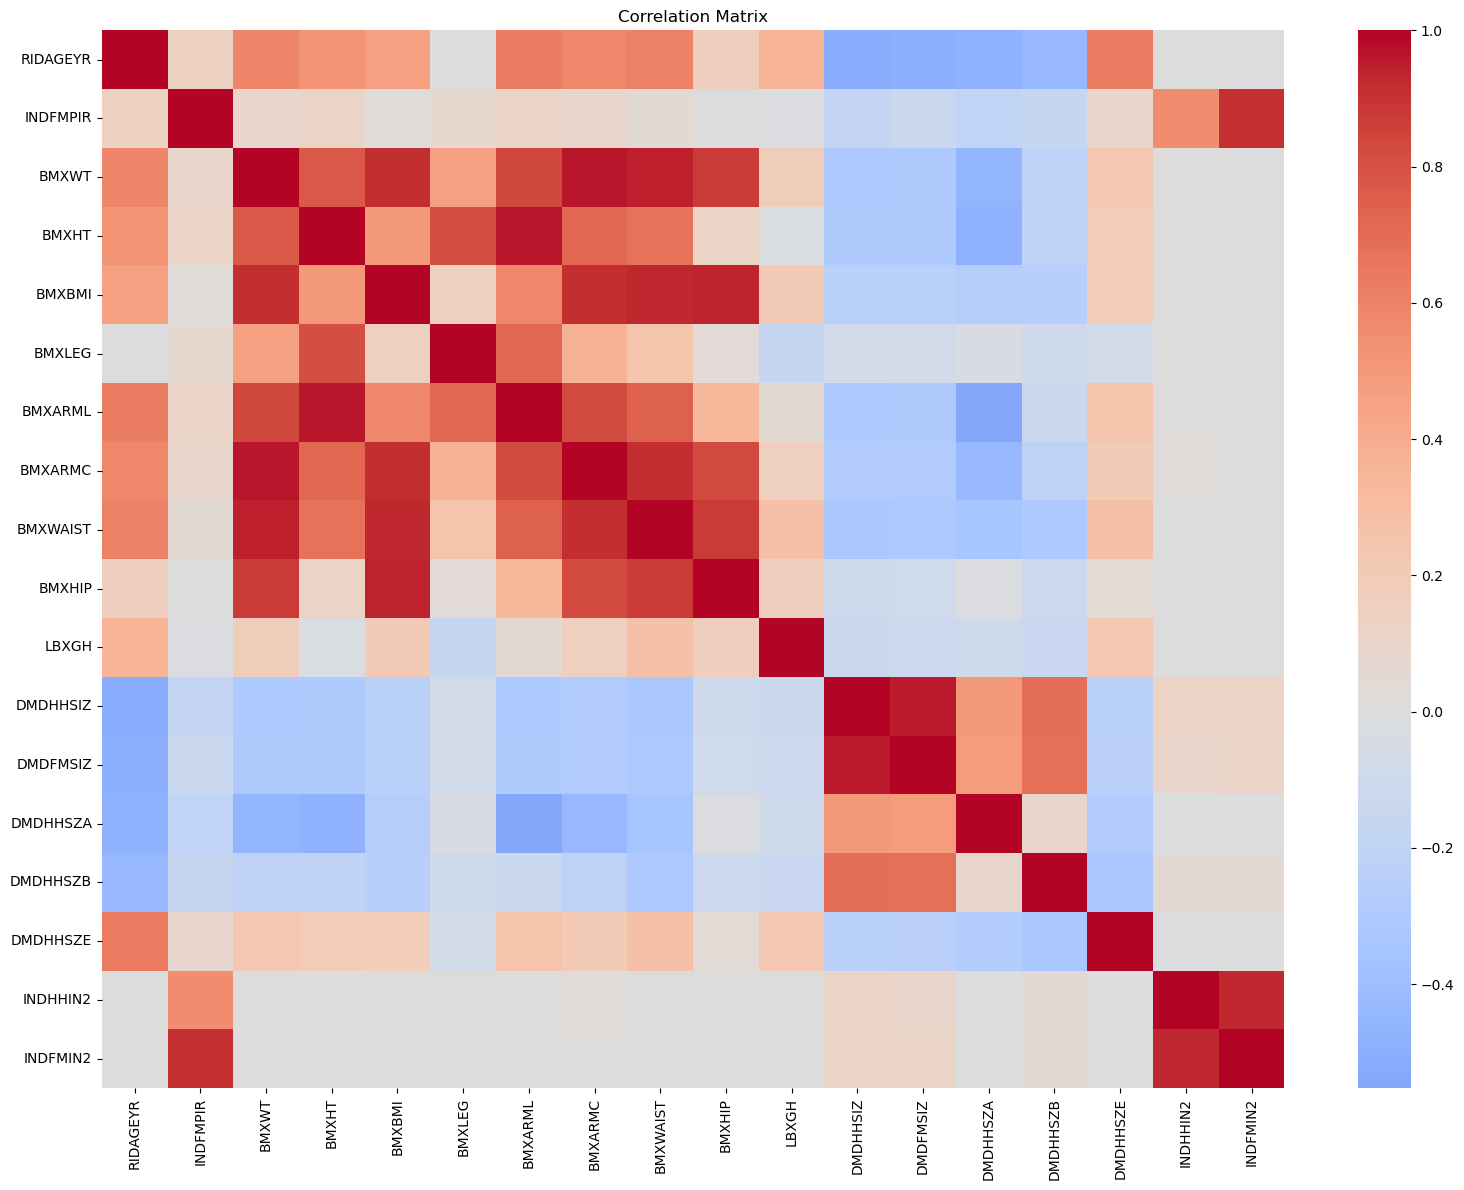

In [55]:
# Running Correlation Analysis on Numerical Features

df_corr = df[numeric_vars].drop(columns=["SEQN"], errors="ignore")

corr_matrix = df_corr.corr(method='pearson')
print((corr_matrix > 0.9).sum())

# Visualize
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, annot=False)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

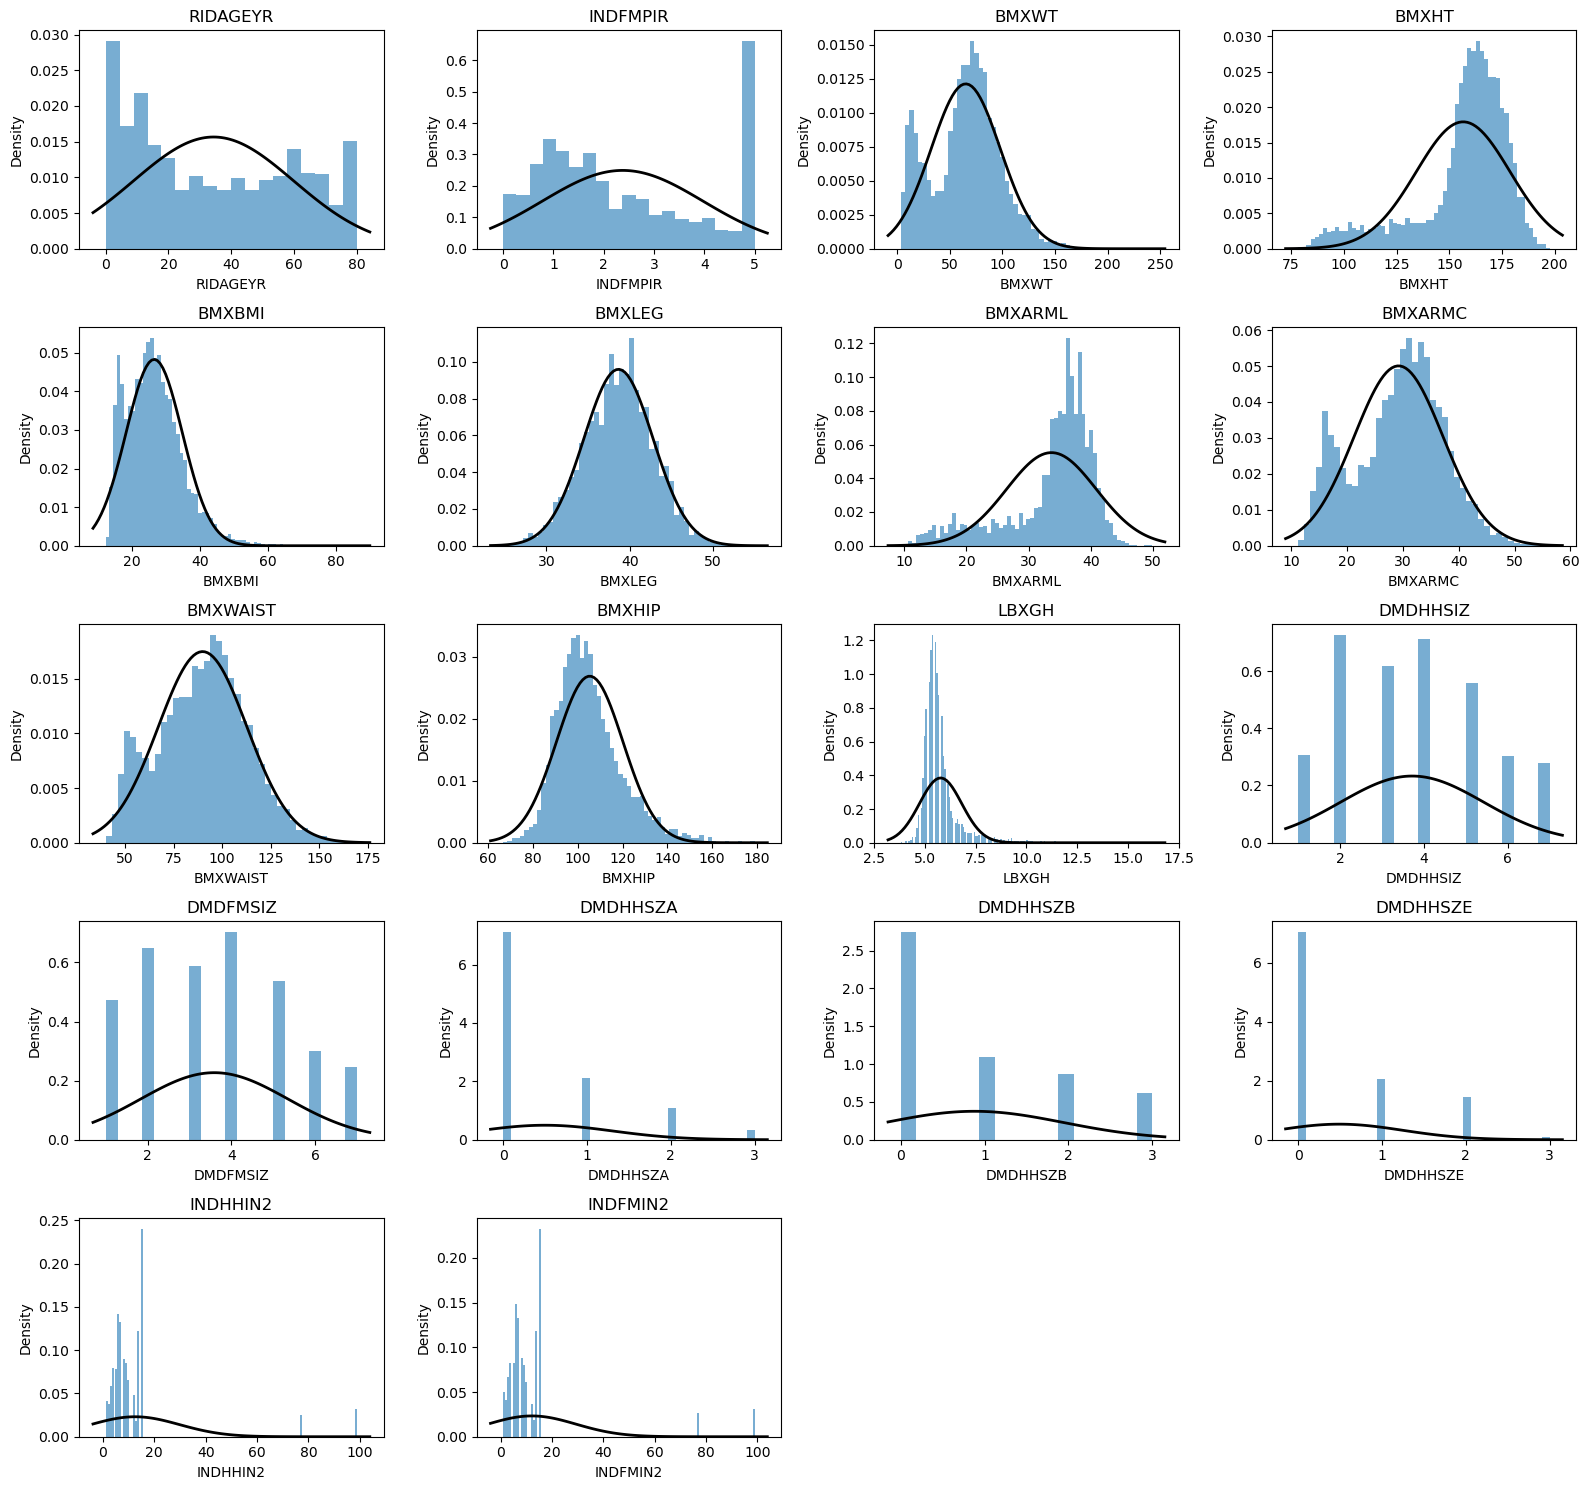

In [46]:
# Plotting Distributions of Numerical Vars

# Define grid size
n_cols = 4  # Number of histograms per row
n_rows = math.ceil(len(df[numeric_vars].columns) / n_cols)


# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3))
axes = axes.flatten()


# Plot histograms
for i, col in enumerate(df[numeric_vars].columns):
    data = df[numeric_vars][col].dropna()
    
    # Histogram
    axes[i].hist(data, bins='auto', density=True, alpha=0.6)
    
    # Fit normal distribution
    mu, sigma = norm.fit(data)
    
    # Overlay normal PDF
    xmin, xmax = axes[i].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, sigma)
    axes[i].plot(x, p, 'k', linewidth=2)
    
    # Titles and labels
    axes[i].set_title(f"{col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Density")

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### Categorical Feature Analysis:

In [47]:
# Counting Number of unique values for each categorical value

df[categorical_vars].nunique()

RIAGENDR    2
RIDRETH1    5
RIDRETH3    6
DMQMILIZ    4
DMDBORN4    4
DMDCITZN    4
DMDEDUC2    7
DMDMARTL    7
dtype: int64

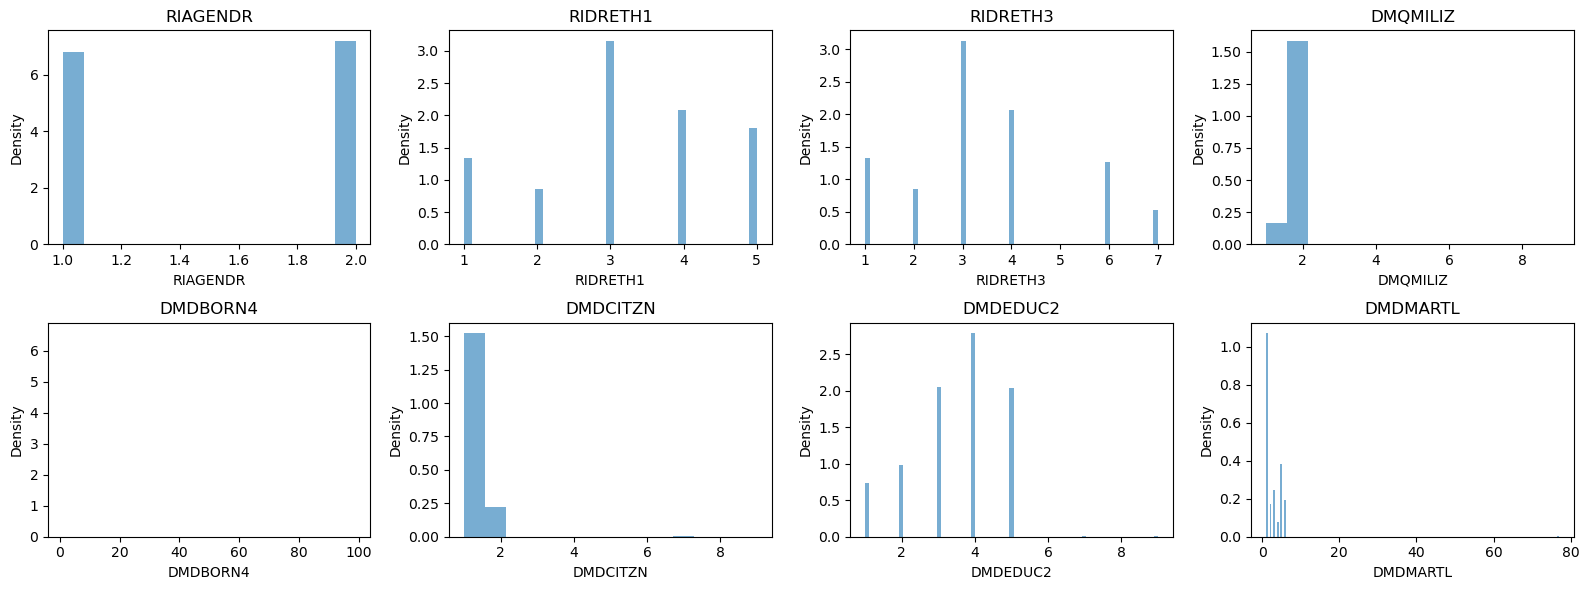

In [ ]:
# Plotting Distributions of categorical data

# Define grid size
n_cols = 4  # Number of histograms per row
n_rows = math.ceil(len(df[categorical_vars].columns) / n_cols)


# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3))
axes = axes.flatten()

# Plot histograms
for i, col in enumerate(df[categorical_vars].columns):
    data = df[categorical_vars][col].dropna()
    
    # Histogram
    axes[i].hist(data, bins='auto', density=True, alpha=0.6)
    
    # Fit normal distribution
    mu, sigma = norm.fit(data)
    
    axes[i].set_title(f"{col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Density")

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
# Analyzing Class Imbalances

for col in categorical_vars:
    print(f"Variable: {col}")
    counts = df[col].value_counts(normalize=True, dropna=False).sort_index()
    for val, pct in counts.items():
        print(f"  Class {val}: {pct:.2%}")
    print()


Variable: RIAGENDR
  Class 1.0: 48.54%
  Class 2.0: 51.46%

Variable: RIDRETH1
  Class 1.0: 14.49%
  Class 2.0: 9.21%
  Class 3.0: 34.18%
  Class 4.0: 22.58%
  Class 5.0: 19.54%

Variable: RIDRETH3
  Class 1.0: 14.49%
  Class 2.0: 9.21%
  Class 3.0: 34.18%
  Class 4.0: 22.58%
  Class 6.0: 13.83%
  Class 7.0: 5.71%

Variable: DMQMILIZ
  Class 1.0: 8.30%
  Class 2.0: 80.96%
  Class 7.0: 0.03%
  Class 9.0: 0.02%
  Class nan: 10.69%

Variable: DMDBORN4
  Class 1.0: 72.16%
  Class 2.0: 27.79%
  Class 77.0: 0.03%
  Class 99.0: 0.02%

Variable: DMDCITZN
  Class 1.0: 87.01%
  Class 2.0: 12.62%
  Class 7.0: 0.23%
  Class 9.0: 0.08%
  Class nan: 0.05%

Variable: DMDEDUC2
  Class 1.0: 7.11%
  Class 2.0: 9.46%
  Class 3.0: 19.78%
  Class 4.0: 26.83%
  Class 5.0: 19.64%
  Class 7.0: 0.03%
  Class 9.0: 0.15%
  Class nan: 16.99%

Variable: DMDMARTL
  Class 1.0: 41.49%
  Class 2.0: 6.73%
  Class 3.0: 9.45%
  Class 4.0: 3.01%
  Class 5.0: 14.81%
  Class 6.0: 7.44%
  Class 77.0: 0.08%
  Class nan: 16.99

## Target Analysis

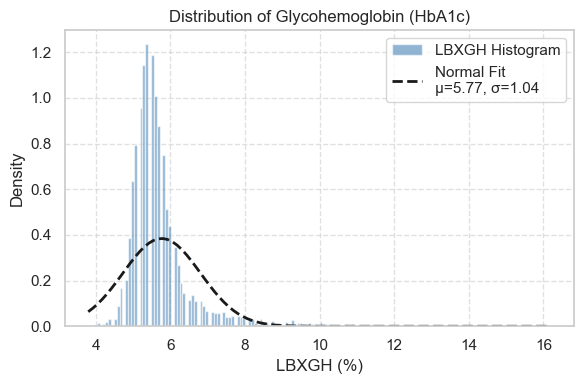

In [80]:
# Fit a normal distribution to the LBXGH data
mu, sigma = norm.fit(df['LBXGH'].dropna())

# Create the histogram
plt.figure(figsize=(6, 4))
count, bins, _ = plt.hist(
    df['LBXGH'].dropna(),
    bins='auto',
    density=True,
    alpha=0.6,
    color='steelblue',
    label='LBXGH Histogram'
)

# Plot the fitted normal distribution
x = np.linspace(bins[0], bins[-1], 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, 'k--', linewidth=2, label=f'Normal Fit\nμ={mu:.2f}, σ={sigma:.2f}')

# Final plot touches
plt.title("Distribution of Glycohemoglobin (HbA1c)")
plt.xlabel("LBXGH (%)")
plt.ylabel("Density")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


In [71]:
# Finding Absolute Correlation with target var from Numerical Vars

correlationsp = df[numeric_vars].corrwith(df["LBXGH"], method='pearson')
correlationsp = abs(correlationsp).sort_values(ascending=False)

correlationsk = df[numeric_vars].corrwith(df["LBXGH"], method='kendall')
correlationsk = abs(correlationsk.sort_values(ascending=False))

correlationss = df[numeric_vars].corrwith(df["LBXGH"], method='spearman')
correlationss = abs(correlationss.sort_values(ascending=False))


In [ ]:
# Running one-way anova on categorical vars

from scipy.stats import f_oneway

for var in categorical_vars:
    groups = [df[df[var] == level]["LBXGH"].dropna() for level in df[var].dropna().unique()]
    try:
        f_stat, p_val = f_oneway(*groups)
        print(f"{var}: F = {f_stat:.4f}, p = {p_val:.4g}")
    except ValueError:
        print(f"{var}: Skipped (not enough data or levels)")


In [ ]:
from itertools import combinations

target = "LBXGH"

for var1, var2 in combinations(categorical_vars, 2):
    try:
        formula = f'{target} ~ C({var1}) + C({var2}) + C({var1}):C({var2})'
        model = ols(formula, data=df).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        print(f"\nTwo-Way ANOVA: {var1} x {var2}")
        print(anova_table)
    except Exception as e:
        print(f"Skipped {var1} x {var2}: {e}")


## Imputation

### Numerical Imputation

In [ ]:
#from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
#from sklearn.ensemble import HistGradientBoostingRegressor


scaler = StandardScaler()
scaled_df = scaler.fit_transform(df[numeric_vars])

reg = RandomForestRegressor(n_estimators=100)

mice_imputer = IterativeImputer(
    estimator=reg,
    max_iter=100, 
    tol=1e-3,
    verbose=2,
    random_state=0,
    imputation_order='roman')

X_imputed = mice_imputer.fit_transform(scaled_df)

[IterativeImputer] Completing matrix with shape (6045, 18)
[IterativeImputer] Ending imputation round 1/100, elapsed time 4.21
[IterativeImputer] Change: 13.017304620524614, scaled tolerance: 0.010050991549250356 
[IterativeImputer] Ending imputation round 2/100, elapsed time 8.39
[IterativeImputer] Change: 4.860082958860767, scaled tolerance: 0.010050991549250356 
[IterativeImputer] Ending imputation round 3/100, elapsed time 12.04
[IterativeImputer] Change: 2.0462802852050115, scaled tolerance: 0.010050991549250356 
[IterativeImputer] Ending imputation round 4/100, elapsed time 15.64
[IterativeImputer] Change: 3.955452192471073, scaled tolerance: 0.010050991549250356 
[IterativeImputer] Ending imputation round 5/100, elapsed time 19.29
[IterativeImputer] Change: 3.1800635181721115, scaled tolerance: 0.010050991549250356 
[IterativeImputer] Ending imputation round 6/100, elapsed time 23.31
[IterativeImputer] Change: 4.022674907946216, scaled tolerance: 0.010050991549250356 
[Iterative

KeyboardInterrupt: 

## Notes:

### Feature Analysis Notes:
- 

### Target Analysis Notes:
- 

### Steps forward for Modeling:
- 